In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import math

from matplotlib import pyplot as plt
from IPython import display

In [2]:
import splitfolders
splitfolders.ratio('./data/anet_original', output="./data/anet", seed=1337, ratio=(.8, 0.1,0.1)) 

In [3]:
PATH = './data/anet'
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100


In [4]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def customGenerator(input_file_paths, type):
    type = type.decode('UTF-8')
    for i, file_path in enumerate(input_file_paths):
        file_name = str(file_path).split('/')[-1][:-1]

        path_input = f"{PATH}/{type}/luc/{file_name}"
        path_real = f"{PATH}/{type}/aerial/{file_name}"

        input_image = tf.io.read_file(path_input)
        input_image = tf.io.decode_png(input_image, channels=3)

        real_image = tf.io.read_file(path_real)
        real_image = tf.io.decode_png(real_image, channels=3)

        input_image = tf.cast(input_image, tf.float32)
        real_image = tf.cast(real_image, tf.float32)

        if type == 'train':
          input_image, real_image = random_jitter(input_image, real_image)
        else:
          input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
      
        yield normalize(input_image, real_image)



test_input_images = [f"{PATH}/test/aerial/{name}" for name in os.listdir(f"{PATH}/test/aerial/")]
dims = (256,256,3)

test_dataset = tf.data.Dataset.from_generator(
    generator=customGenerator,
    output_signature=(tf.TensorSpec(shape=(256,256,3), dtype=tf.float32), tf.TensorSpec(shape=(256,256,3), dtype=tf.float32)),
    args=[test_input_images, 'test']
)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_input_images = [f"{PATH}/train/aerial/{name}" for name in os.listdir(f"{PATH}/train/aerial/")]
train_dataset = tf.data.Dataset.from_generator(
    generator=customGenerator,
    output_signature=(tf.TensorSpec(shape=(256,256,3), dtype=tf.float32), tf.TensorSpec(shape=(256,256,3), dtype=tf.float32)),
    args=[train_input_images, 'train']
)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)




2023-12-11 22:29:19.656101: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-11 22:29:19.656126: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-11 22:29:19.656131: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-11 22:29:19.656172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 22:29:19.656194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [6]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [7]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [8]:
generator = Generator()

In [9]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [10]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [11]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

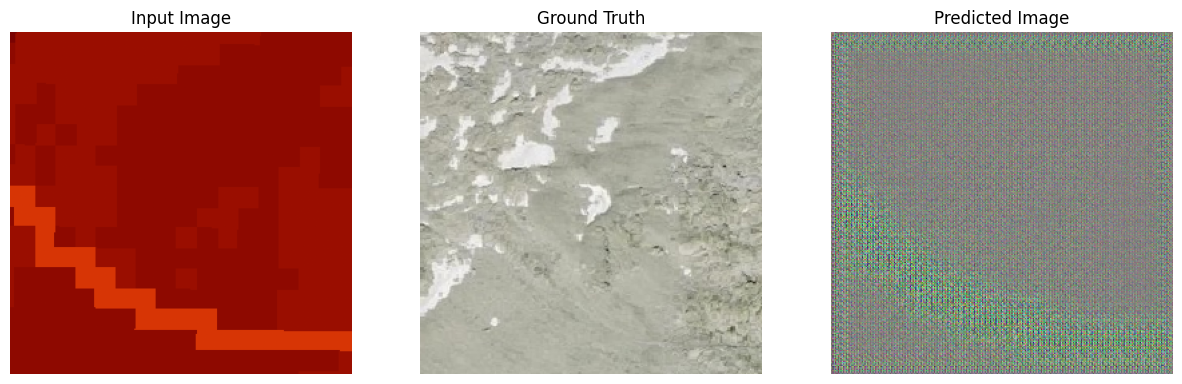

In [11]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [19]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [12]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [172]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [173]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [174]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Time taken for 1000 steps: 60.53 sec



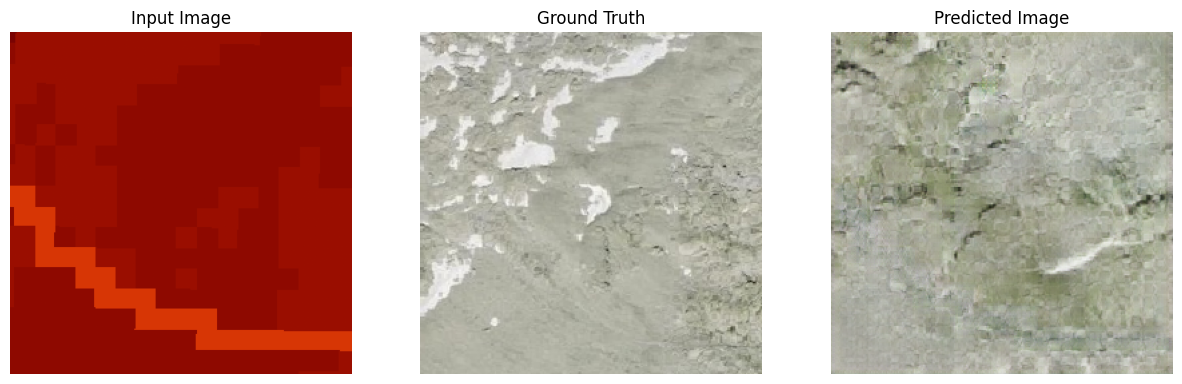

Step: 39k
..........................................

2023-11-14 21:51:42.892596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:578: Filling up shuffle buffer (this may take a while): 166 of 400


.................

2023-11-14 21:51:52.944094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:578: Filling up shuffle buffer (this may take a while): 333 of 400


......

2023-11-14 21:51:56.975750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


...................................

In [184]:
fit(train_dataset, test_dataset, steps=40000)

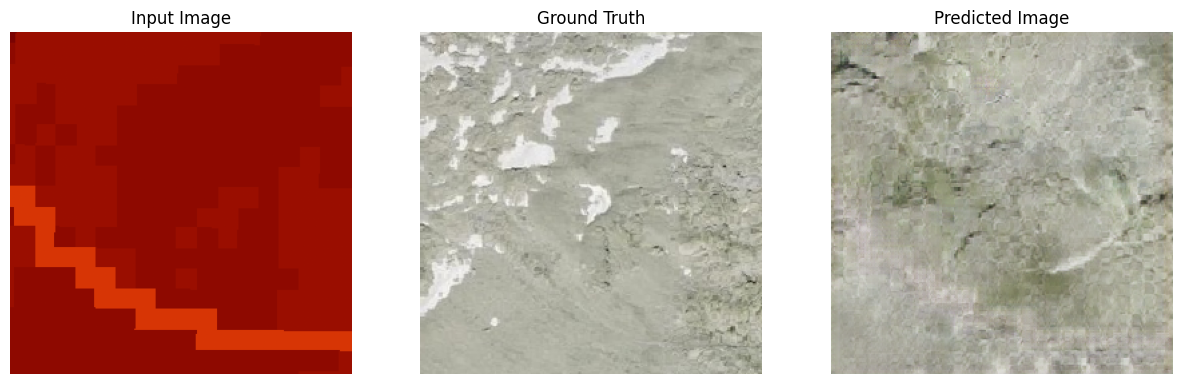

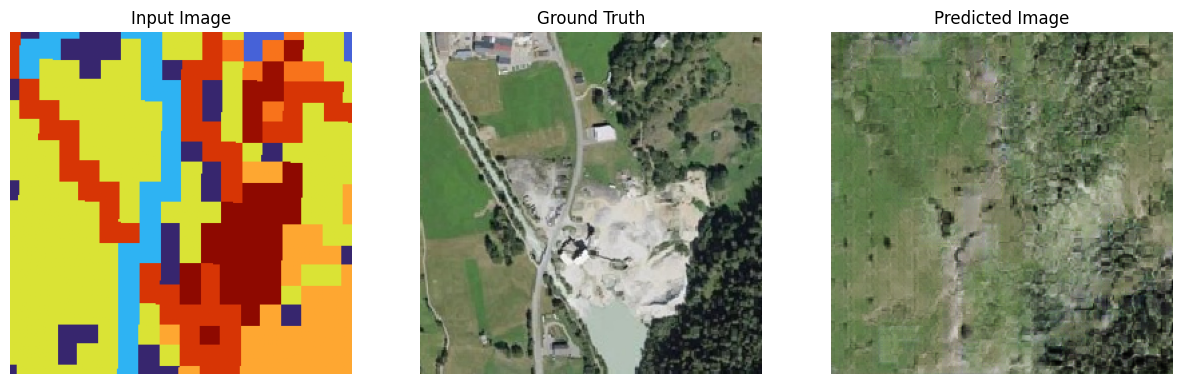

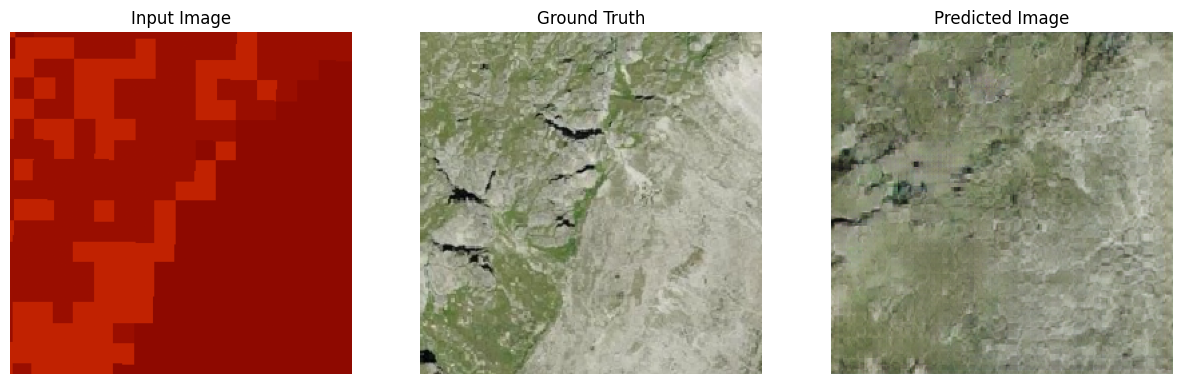

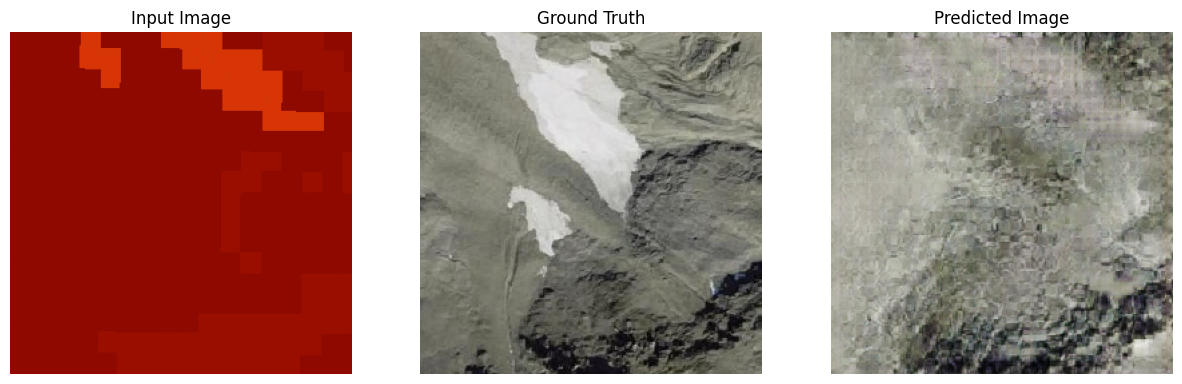

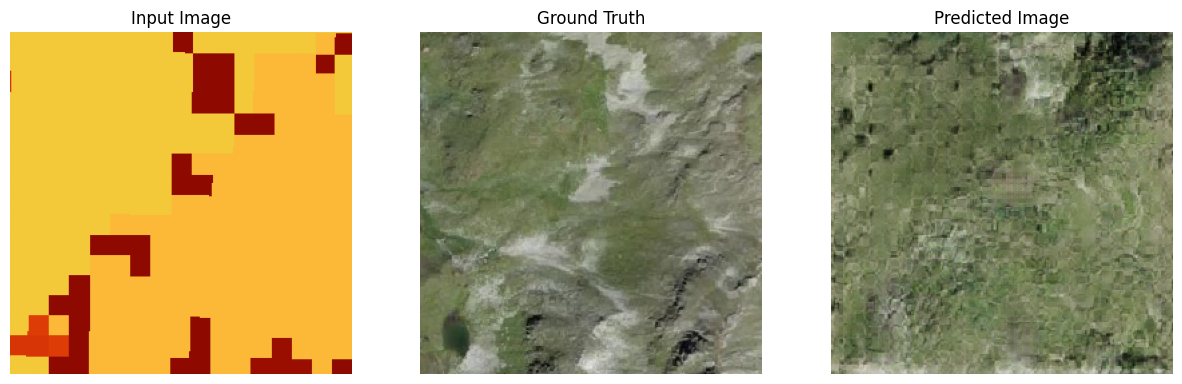

In [14]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)
  

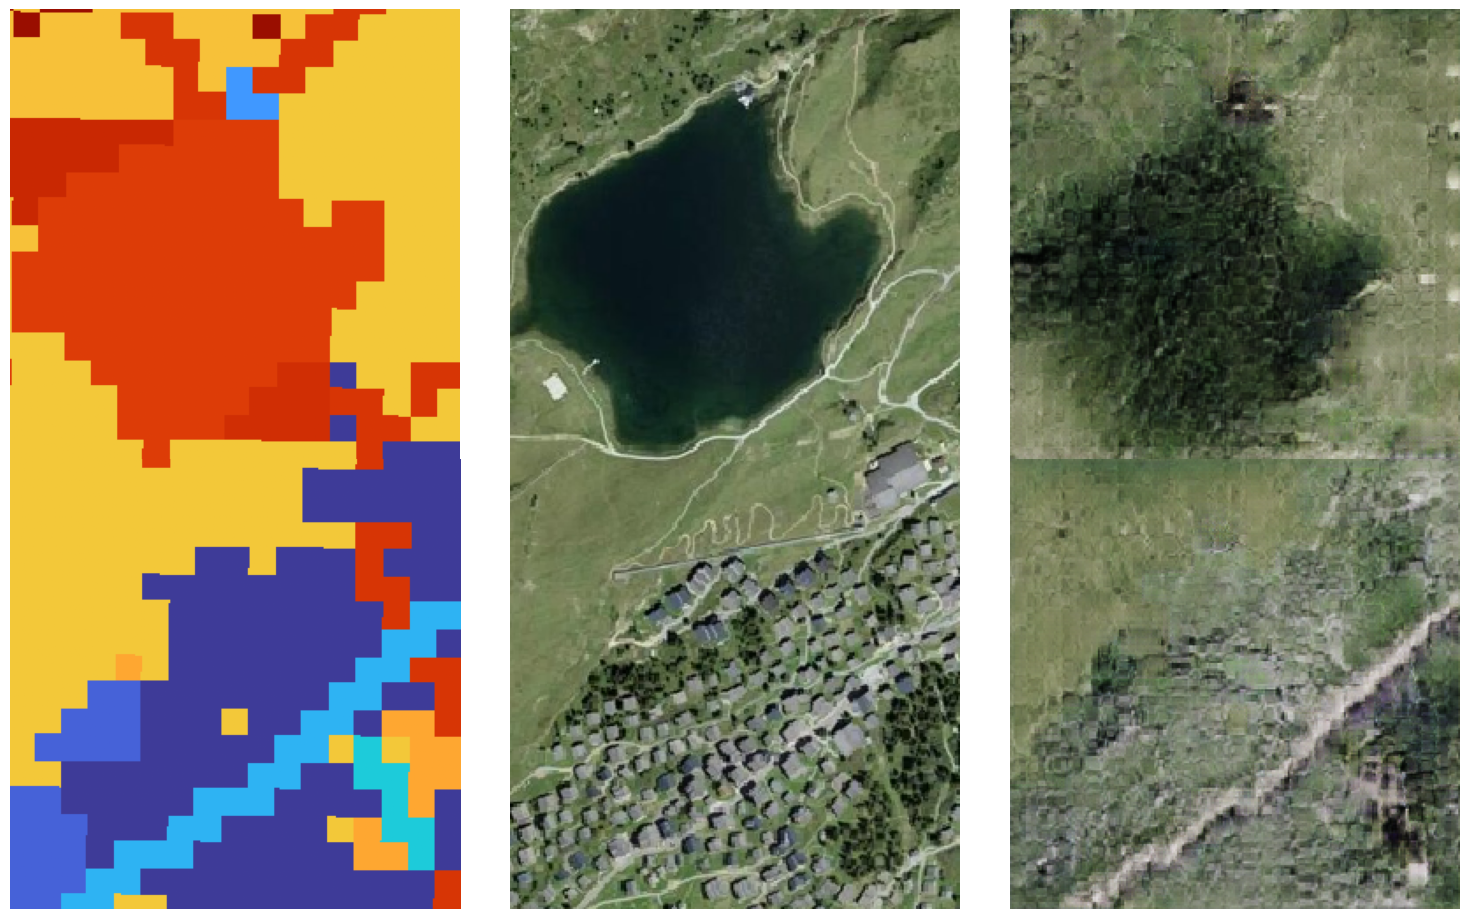

In [15]:
PATH_ORIGINAL = "./data/anet_original"

data = [
  f"{PATH_ORIGINAL}/aerial/0009.png",
  f"{PATH_ORIGINAL}/aerial/0002.png",
  f"{PATH_ORIGINAL}/aerial/0001.png",
  f"{PATH_ORIGINAL}/aerial/0015.png",
  f"{PATH_ORIGINAL}/aerial/0010.png",
  f"{PATH_ORIGINAL}/aerial/0017.png",
  f"{PATH_ORIGINAL}/aerial/0018.png",
]

def test_generator(input_file_paths):
    for i, file_path in enumerate(input_file_paths):
      file_name = str(file_path).split('/')[-1][:-1]
      path_input = f"{PATH_ORIGINAL}/luc/{file_name}"
      path_real = f"{PATH_ORIGINAL}/aerial/{file_name}"

      input_image = tf.io.read_file(path_input)
      input_image = tf.io.decode_png(input_image, channels=3)

      real_image = tf.io.read_file(path_real)
      real_image = tf.io.decode_png(real_image, channels=3)

      input_image = tf.cast(input_image, tf.float32)
      real_image = tf.cast(real_image, tf.float32)

      input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)

      yield normalize(input_image, real_image)


ds = tf.data.Dataset.from_generator(
    generator=test_generator,
    output_signature=(tf.TensorSpec(shape=(256,256,3), dtype=tf.float32), tf.TensorSpec(shape=(256,256,3), dtype=tf.float32)),
    args=[data]
)
ds = ds.batch(BATCH_SIZE)

n_cols = 2 #len(data)
fig = plt.figure(
   figsize=(15, 5*n_cols)
)


gs = fig.add_gridspec(
   nrows=n_cols,
   ncols=3,
   left=0,
   right=1,
   bottom=0.1,
   top=1,
   hspace=0,
   wspace=0
)

i = 0
for inp, re in ds.take(n_cols):
  ax = fig.add_subplot(gs[i,0])
  ax.set_axis_off()
  ax.imshow(inp[0] * 0.5 + 0.5)

  ax = fig.add_subplot(gs[i,1])
  ax.set_axis_off()
  ax.imshow(re[0] * 0.5 + 0.5)

  ax = fig.add_subplot(gs[i,2])
  ax.set_axis_off()
  pred = generator(inp, training=True)
  ax.imshow(pred[0] * 0.5 + 0.5)

  i += 1



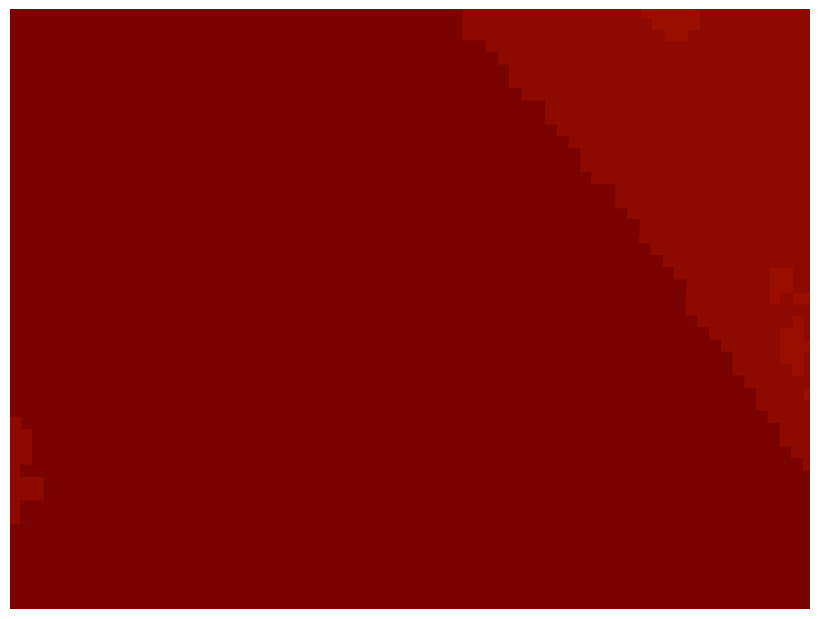

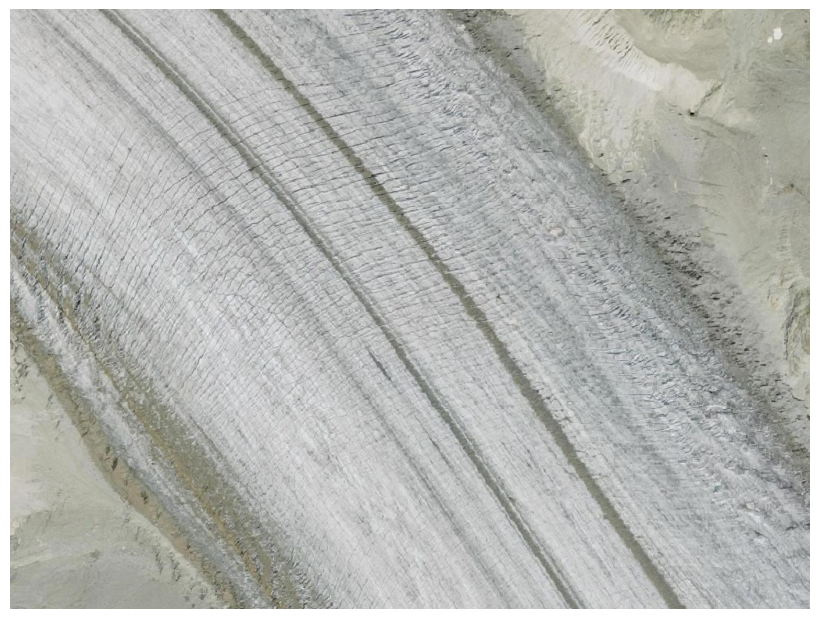

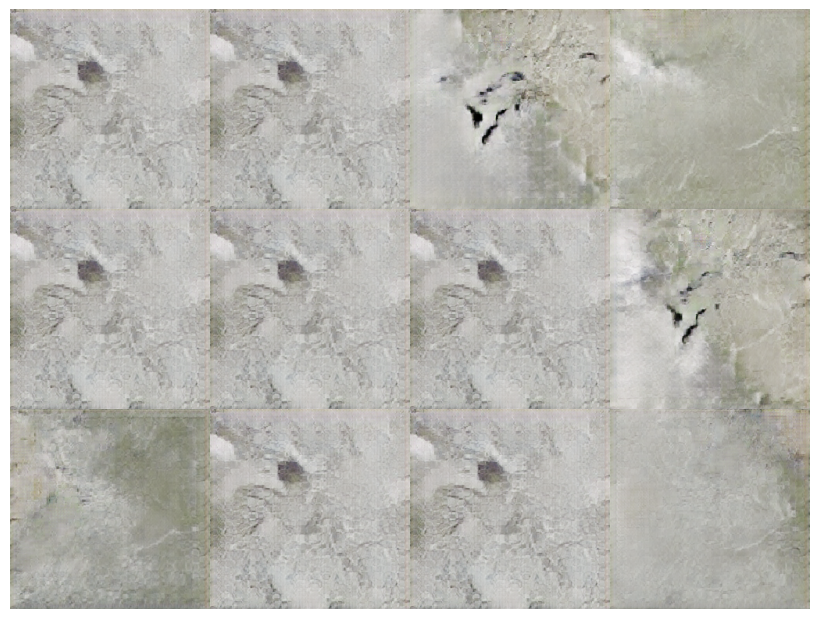

In [26]:
PATH_ORIGINAL = "./data/anet_original"

data = [
  f"{PATH_ORIGINAL}/aerial/0065.png",
  f"{PATH_ORIGINAL}/aerial/0059.png",
  f"{PATH_ORIGINAL}/aerial/0058.png",
  f"{PATH_ORIGINAL}/aerial/0324.png",
  f"{PATH_ORIGINAL}/aerial/0318.png",
  f"{PATH_ORIGINAL}/aerial/0317.png",
  f"{PATH_ORIGINAL}/aerial/0361.png",
  f"{PATH_ORIGINAL}/aerial/0355.png",
  f"{PATH_ORIGINAL}/aerial/0354.png",
  f"{PATH_ORIGINAL}/aerial/0028.png",
  f"{PATH_ORIGINAL}/aerial/0022.png",
  f"{PATH_ORIGINAL}/aerial/0021.png",
]

def test_generator(input_file_paths):
    for i, file_path in enumerate(input_file_paths):
      file_name = str(file_path).split('/')[-1][:-1]
      path_input = f"{PATH_ORIGINAL}/luc/{file_name}"
      path_real = f"{PATH_ORIGINAL}/aerial/{file_name}"

      input_image = tf.io.read_file(path_input)
      input_image = tf.io.decode_png(input_image, channels=3)

      real_image = tf.io.read_file(path_real)
      real_image = tf.io.decode_png(real_image, channels=3)

      input_image = tf.cast(input_image, tf.float32)
      real_image = tf.cast(real_image, tf.float32)

      input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)

      yield normalize(input_image, real_image)


ds = tf.data.Dataset.from_generator(
    generator=test_generator,
    output_signature=(tf.TensorSpec(shape=(256,256,3), dtype=tf.float32), tf.TensorSpec(shape=(256,256,3), dtype=tf.float32)),
    args=[data]
)
ds = ds.batch(BATCH_SIZE)

n_cols = len(data)

fig_lu = plt.figure(
   figsize=(8, 6),
)
gs_lu = fig.add_gridspec(
   nrows=3,
   ncols=4,
   left=0,
   right=1,
   bottom=0,
   top=1,
   hspace=0,
   wspace=0
)

fig_re = plt.figure(
   figsize=(8, 6)
)
gs_re = fig.add_gridspec(
   nrows=3,
   ncols=4,
   left=0,
   right=1,
   bottom=0,
   top=1,
   hspace=0,
   wspace=0
)

fig_ge = plt.figure(
   figsize=(8, 6)
)
gs_ge = fig.add_gridspec(
   nrows=3,
   ncols=4,
   left=0,
   right=1,
   bottom=0,
   top=1,
   hspace=0,
   wspace=0
)

i = 0
for inp, re in ds.take(n_cols):

  row = i%3
  col = math.floor(i/3)

  ax = fig_lu.add_subplot(gs_lu[row,col])
  ax.set_axis_off()
  ax.imshow(inp[0] * 0.5 + 0.5)

  ax = fig_re.add_subplot(gs_re[row,col])
  ax.set_axis_off()
  ax.imshow(re[0] * 0.5 + 0.5)

  ax = fig_ge.add_subplot(gs_ge[row,col])
  ax.set_axis_off()
  pred = generator(inp, training=True)
  ax.imshow(pred[0] * 0.5 + 0.5)

  tf.keras.utils.save_img(f"./out/{i}.png", pred, file_format='png')

  i += 1


